# Setup

In [1]:
import sagemaker
from sagemaker import get_execution_role
import json
import boto3
import pandas as pd


sess = sagemaker.Session()

role = get_execution_role()
print(role) # This is the role that SageMaker would use to leverage AWS resources (S3, CloudWatch) on your behalf

bucket = sess.default_bucket() # Replace with your own bucket name if needed
print(bucket)
prefix = 'bravesouls/supervised/comment'

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-023375022819


arn:aws:iam::023375022819:role/service-role/AmazonSageMaker-ExecutionRole-20181029T121824
sagemaker-us-east-1-023375022819


In [2]:
def prep_data():
    !mkdir Data
    !aws s3 cp s3://aws-ml-chicago-team-bravesouls/amazon_review_polarity_csv.tgz Data
    !tar -xvzf Data/amazon_review_polarity_csv.tgz
#prep_data()

In [8]:
#!head -100000 amazon_review_polarity_csv/train.csv > amazon_review_polarity_csv/train_100k.csv

# Data Processing

In [2]:
from random import shuffle
import multiprocessing
from multiprocessing import Pool
import csv
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
def transform_instance(row):
    cur_row = []
    label = "__label__" + row[0]  #Prefix the index-ed label with __label__
    cur_row.append(label)
    cur_row.extend(nltk.word_tokenize(row[1].lower()+ " "+ row[2].lower()))
    return cur_row

In [4]:
def preprocess(input_file, output_file, keep=1):
    all_rows = []
    with open(input_file, 'r') as csvinfile:
        csv_reader = csv.reader(csvinfile, delimiter=',')
        for row in csv_reader:
            all_rows.append(row)
    shuffle(all_rows)
    all_rows = all_rows[:int(keep*len(all_rows))]
    pool = Pool(processes=multiprocessing.cpu_count())
    transformed_rows = pool.map(transform_instance, all_rows)
    pool.close() 
    pool.join()
    
    with open(output_file, 'w') as csvoutfile:
        csv_writer = csv.writer(csvoutfile, delimiter=' ', lineterminator='\n')
        csv_writer.writerows(transformed_rows)

In [5]:
%%time
# Preparing the training dataset

# Since preprocessing the whole dataset might take a couple of mintutes,
# we keep 20% of the training dataset for this demo.
# Set keep to 1 if you want to use the complete dataset
preprocess('amazon_review_polarity_csv/train.csv', 'amazon_review_polarity.train', keep=.5)
        
# Preparing the validation dataset        
preprocess('amazon_review_polarity_csv/test.csv', 'amazon_review_polarity.validation', keep=.5)

CPU times: user 1min 24s, sys: 13 s, total: 1min 37s
Wall time: 7min 25s


In [6]:
%%time

train_channel = prefix + '/train'
validation_channel = prefix + '/validation'

sess.upload_data(path='amazon_review_polarity.train', bucket=bucket, key_prefix=train_channel)
sess.upload_data(path='amazon_review_polarity.validation', bucket=bucket, key_prefix=validation_channel)

s3_train_data = 's3://{}/{}'.format(bucket, train_channel)
s3_validation_data = 's3://{}/{}'.format(bucket, validation_channel)

CPU times: user 5.81 s, sys: 4.53 s, total: 10.3 s
Wall time: 5.36 s


In [7]:
s3_output_location = 's3://{}/{}/output'.format(bucket, prefix)

In [8]:
region_name = boto3.Session().region_name

In [9]:
container = sagemaker.amazon.amazon_estimator.get_image_uri(region_name, "blazingtext", "latest")
print('Using SageMaker BlazingText container: {} ({})'.format(container, region_name))

Using SageMaker BlazingText container: 811284229777.dkr.ecr.us-east-1.amazonaws.com/blazingtext:latest (us-east-1)


In [10]:
bt_model = sagemaker.estimator.Estimator(container,
                                         role, 
                                         base_job_name= "Gaj-BraveSouls",
                                         train_instance_count=1, 
                                         train_instance_type='ml.c4.4xlarge',
                                         train_volume_size = 30,
                                         train_max_run = 360000,
                                         input_mode= 'File',
                                         output_path=s3_output_location,
                                         sagemaker_session=sess)

In [11]:
bt_model.set_hyperparameters(mode="supervised",
                            epochs=10,
                            min_count=2,
                            learning_rate=0.05,
                            vector_dim=10,
                            early_stopping=True,
                            patience=4,
                            min_epochs=5,
                            word_ngrams=2)

In [12]:
train_data = sagemaker.session.s3_input(s3_train_data, distribution='FullyReplicated', 
                        content_type='text/plain', s3_data_type='S3Prefix')
validation_data = sagemaker.session.s3_input(s3_validation_data, distribution='FullyReplicated', 
                             content_type='text/plain', s3_data_type='S3Prefix')
data_channels = {'train': train_data, 'validation': validation_data}

In [13]:
bt_model.fit(inputs=data_channels, logs=True)

INFO:sagemaker:Creating training-job with name: Gaj-BraveSouls-2019-01-10-03-55-21-591


2019-01-10 03:55:21 Starting - Starting the training job...
2019-01-10 03:55:22 Starting - Launching requested ML instances......
2019-01-10 03:56:29 Starting - Preparing the instances for training...
2019-01-10 03:57:10 Downloading - Downloading input data..
Arguments: train
[01/10/2019 03:57:34 WARNING 140573396776768] Loggers have already been setup.
[01/10/2019 03:57:34 WARNING 140573396776768] Loggers have already been setup.
[01/10/2019 03:57:34 INFO 140573396776768] nvidia-smi took: 0.0251839160919 secs to identify 0 gpus
[01/10/2019 03:57:34 INFO 140573396776768] Running single machine CPU BlazingText training using supervised mode.
[01/10/2019 03:57:34 INFO 140573396776768] Processing /opt/ml/input/data/train/amazon_review_polarity.train . File size: 781 MB
[01/10/2019 03:57:34 INFO 140573396776768] Processing /opt/ml/input/data/validation/amazon_review_polarity.validation . File size: 86 MB
Read 10M words
Read 20M words
Read 30M words
Read 40M words
Read 50M words
Read 60M wo

In [14]:
text_classifier = bt_model.deploy(initial_instance_count = 1,instance_type = 'ml.m4.xlarge')

INFO:sagemaker:Creating model with name: blazingtext-2019-01-10-03-59-59-975
INFO:sagemaker:Creating endpoint with name Gaj-BraveSouls-2019-01-10-03-55-21-591


----------------------------------------------------------------------------!

In [15]:
def create_prediction_request(inputs):
    # using the same nltk tokenizer that we used during data preparation for training
    tokenized_sentences = [' '.join(nltk.word_tokenize(sent)) for sent in inputs]
    return json.dumps({"instances" : tokenized_sentences})

In [17]:
sentences = ["This product sucks",
            "A very good buy. I really recommend",
            "Bad design. Very hard to use",
            "I'm very satisfied. The best buy ever!!"
    ]


payload=create_prediction_request(sentences)
response = text_classifier.predict(payload)
predictions = json.loads(response)
print(json.dumps(predictions, indent=2))

[
  {
    "prob": [
      1.0000100135803223
    ],
    "label": [
      "__label__1"
    ]
  },
  {
    "prob": [
      1.0000076293945312
    ],
    "label": [
      "__label__2"
    ]
  },
  {
    "prob": [
      0.9999821186065674
    ],
    "label": [
      "__label__1"
    ]
  },
  {
    "prob": [
      1.0000100135803223
    ],
    "label": [
      "__label__2"
    ]
  }
]


In [21]:
import seaborn as sns

label_map={
    "__label__1":"-Ve",
    "__label__2":'+Ve'
}

def count_matches(a,b):
    return len(get_matches(a,b))

def get_matches(a,b):
    return [i for i, j in zip(a, b) if i == j]

def get_mismatches(a,b):
    return [i for i, j in zip(a, b) if i != j]
    
def evaluate_metrics(predictor, test_features, test_labels):
    """
    Evaluate a model on a test set using the given prediction endpoint. Display classification metrics.
    """
    # split the test dataset into 100 batches and evaluate using prediction endpoint
    prediction_batches = [predictor.predict(create_prediction_request(batch)) for batch in np.array_split(test_features, 10)]

    # parse protobuf responses to extract predicted labels
    extract_label = lambda x: x['label'][0]
    test_preds = np.concatenate([np.array([extract_label(x) for x in json.loads(batch)]) for batch in prediction_batches])

    # calculate accuracy
    
    accuracy = count_matches(test_preds, test_labels) / len(test_labels)
    #accuracy = (test_preds == test_labels).sum() / len(test_labels)
    
    true_matches=get_matches(test_preds, test_labels)
    mis_matches=get_mismatches(test_preds, test_labels)
    # calculate recall for each class
    recall_per_class,precision_per_class, classes = [], [], []
    for target_label in np.unique(test_labels):
        true_positives = len([r for r in true_matches if r==target_label])
        recall_denominator = len ([r for r in test_labels if r==target_label])
        recall_per_class.append(true_positives / recall_denominator)
        precision_denominator = len([r for r in test_preds if r==target_label])
        precision_per_class.append(true_positives / precision_denominator)
        classes.append(label_map[target_label])
    recall = pd.DataFrame({'recall': recall_per_class, 'class_label': classes})
    recall.sort_values('class_label', ascending=False, inplace=True)
    
    precision = pd.DataFrame({'precision': precision_per_class, 'class_label': classes})
    precision.sort_values('class_label', ascending=False, inplace=True)

    # calculate confusion matrix
    label_mapper = np.vectorize(lambda x: label_map[x])
    confusion_matrix = pd.crosstab(label_mapper(test_labels), label_mapper(test_preds), 
                                   rownames=['Actuals'], colnames=['Predictions'], normalize='index')

    # display results
    sns.heatmap(confusion_matrix, annot=True, fmt='.2f', cmap="YlGnBu").set_title('Confusion Matrix')  
    recal_chart = recall.plot(kind='barh', x='class_label', y='recall', color='steelblue', title='Recall', legend=False)
    recal_chart.set_ylabel('')
    
    precision_chart = precision.plot(kind='barh', x='class_label', y='precision', color='steelblue', title='Precision', legend=False)
    precision_chart.set_ylabel('')
    print('Accuracy: {:.3f}'.format(accuracy))
    #print(recall)

In [19]:
import numpy as np
from sklearn.model_selection import train_test_split

def transform_test_rec(row):
    cur_row = []
    label = "__label__" + row[0]  #Prefix the index-ed label with __label__
    cur_row.append(label)
    cur_row.append(row[1].lower()+ " "+ row[2].lower())
    return cur_row

def create_test_sets(input_file):
    all_rows = []
    with open(input_file, 'r') as csvinfile:
        csv_reader = csv.reader(csvinfile, delimiter=',')
        for row in csv_reader:
            all_rows.append(row)
    shuffle(all_rows)
    pool = Pool(processes=multiprocessing.cpu_count())
    transformed_rows = pool.map(transform_test_rec, all_rows)
    pool.close() 
    pool.join()
    test_labels=[row[0] for row in transformed_rows]
    test_features=[row[1] for row in transformed_rows]
    return test_features,test_labels
     
    
test_features, test_labels = create_test_sets('amazon_review_polarity_csv/test_100.csv')

Accuracy: 0.950


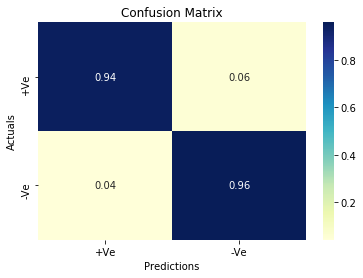

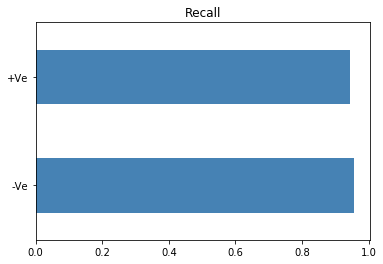

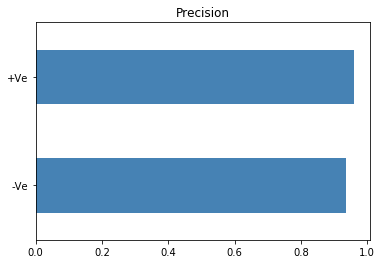

In [22]:
evaluate_metrics(text_classifier,test_features,test_labels)